# Week 11 Exercises (13-1)

## Exercise 13-1
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the
respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far,
of marriages that are ongoing. Estimate the hazard and survival function for the duration
of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples
to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age
at first marriage.

In [9]:
import nsfg
import thinkstats2
import survival
import numpy as np
import matplotlib.pyplot as plt
import thinkplot
import pandas as pd

In [10]:
def CleanResp(resp):  
    # clean divorce and marriage variables
    resp.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
    resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
    # creates variables for those not divorced
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    # duration of marriages that ended in divorce
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    #computes duration of those still married
    resp['duration_now'] = (resp.cmintvw - resp.cmmarrhx) / 12.0
    # modify months for grouping by decades
    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [11]:
resp6 = survival.ReadFemResp2002()
CleanResp(resp6)
married6 = resp6[resp6.evrmarry == 1]

resp7 = survival.ReadFemResp2010()
CleanResp(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [14]:
def EstimateDivorce(resp):
    """calculates hazard and survival function 
    for divorces
    """
    # variables for those divorced and those still married
    complete = resp[resp.notdivorced== 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].duration_now.dropna()
    
    # hazard function for duration of marriage
    haz = survival.EstimateHazardFunction(complete, ongoing)
    # survival function for duration of marriage
    surv = haz.MakeSurvival()
    return haz, surv

In [13]:
def ResampleDivorce(resps):
    """Resamples respondents and computes survival function 
    to account for sampling weights"""
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)
    thinkplot.Config(xlabel = "years", axis = [0, 28, 0, 1])

In [15]:
def ResampleDivorceByDecade(resps):
    """Plots divorce curves for each birth cohort.
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [16]:
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateDivorce(group)
        thinkplot.Plot(sf, **options)

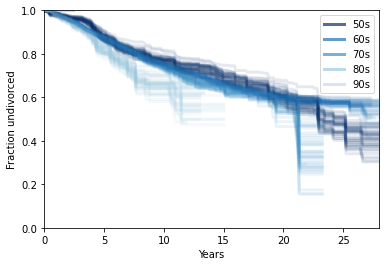

In [17]:
ResampleDivorceByDecade([married6, married7])